# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.5 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Note that **in this coding environment, you will not be able to watch the agents while they are training**, and you should set `train_mode=True` to restart the environment.

In [ ]:
for i in range(5):                                         # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [5]:
#env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

### 1. Imports and Hyperparameter settings
---
Import all necessary libraries and set the hyperparameter for the neural network, the agents learning behaviour and the replay buffer, as well as noise parameters.

In [10]:
import random
import copy
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from collections import namedtuple, deque
import matplotlib.pyplot as plt
%matplotlib inline


FC1_UNITS = 200
FC2_UNITS = 150

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic 
WEIGHT_DECAY = 0        # L2 weight decay

RANDOM_SEED = 0
MU = 0.
THETA = 0.15
SIGMA = 0.2
SCALE = 1
NUM_EPISODES = 1000
PRINT_EVERY = 100

DELAY_UPDATE = 2
NOISE_DECAY = 0.9999

### 2. Device and hidden layer init
---
Use GPU / CUDA if available, else run on a CPU.
Normalize the networks weights once before starting training to accelerate convergence.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

### 3. Actor Class
---
Define the Actor Class using three linear layers and applying a tanh activation function on the output.

In [ ]:
class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed, fc1_units=FC1_UNITS, fc2_units=FC2_UNITS):
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))


### 3. Define the Critic
---
The critic maps states and actions to Q-values, using three linear layers.

In [ ]:
class Critic(nn.Module):

    def __init__(self, state_size, action_size, seed, fcs1_units=FC1_UNITS, fc2_units=FC2_UNITS):
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size)*num_agents, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
    
    def forward(self, state, action):
        xs1 = torch.cat((state, action), dim=1)
        x1 = F.relu(self.fcs1(xs1))
        x1 = F.relu(self.fc2(x1))
        x1 = self.fc3(x1)
        return x1
    

### 4. Ornstein-Uhlenbeck Noise
---

In [ ]:
class OUNoise(object):
    def __init__(self, action_dimension, seed, scale=SCALE, mu=MU, theta=THETA, sigma=SIGMA):
        self.size = action_dimension
        self.scale = scale
        self.theta = theta
        self.sigma = sigma
        self.mu = mu * np.ones(action_dimension)
        self.seed = random.seed(seed)
        self.reset()
    
    def reset(self):
        self.state = copy.copy(self.mu)
        
    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.randn(self.size)
        self.state = x + dx
        return self.state

### 5. Replay Buffer / Memory
---

In [ ]:
class ReplayBuffer(object):
    def __init__(self, action_size, buffer_size, batch_size, seed):
        self.seed = random.seed(seed)
        self.batch_size = batch_size
        self.action_size = action_size
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names = ["state", "action", "reward", "next_state", "done"])
    
    def add(self, state, action, reward, next_state, done):
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states = [torch.from_numpy(np.vstack([e.state[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        actions = [torch.from_numpy(np.vstack([e.action[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = [torch.from_numpy(np.vstack([e.next_state[idx] for e in experiences if e is not None])).float().to(device) for idx in range(num_agents)]
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        return len(self.memory)
    
memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, RANDOM_SEED)

### 6. Agent: Actor-Critic
---
Define a Deep-Deterministic Policy Gradient Agent that learns in the environment.

In [ ]:
class DDPGAgent():
    def __init__(self, state_size, action_size, random_seed):
        self.state_size = state_size
        self.action_size = action_size
        
        self.learn_counter = 0
        
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = torch.optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)
        
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = torch.optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)
        
        self.noise = OUNoise(action_size, random_seed)
        self.noise_decay = NOISE_DECAY

        
    def step(self):
        if len(memory) > BATCH_SIZE:
            experiences = memory.sample()
            self.learn(experiences, GAMMA)
            
    def act(self, state, add_noise = True):
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample() #* self.noise_decay
            #self.noise_decay *= self.noise_decay
            
        return np.clip(action, -1, 1)
    
    def reset(self):
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        self.learn_counter += 1
        states_l, actions_l, rewards, next_states_l, dones = experiences
        
        states_t = torch.cat(states_l, dim=1).to(device)
        actions_t = torch.cat(actions_l, dim=1).to(device)
        next_states_t = torch.cat(next_states_l, dim=1).to(device)
        
        next_actions_l = [self.actor_target(next_state) for next_state in next_states_l]
        next_actions_t = torch.cat(next_actions_l, dim=1).to(device)
        
        target_Q = self.critic_target.forward(next_states_t, next_actions_t)
        Q_targets = rewards + (gamma * target_Q * (1-dones))
        
        currentQ = self.critic_local.forward(states_t, actions_t)
        
        critic_loss = F.mse_loss(currentQ, Q_targets)  
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        actions_pred_l = [self.actor_local(state) for state in states_l]
        actions_pred_t = torch.cat(actions_pred_l, dim=1).to(device)

        actor_loss = -self.critic_local(states_t, actions_pred_t).mean()

        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.actor_local.parameters(), 0.5)
        self.actor_optimizer.step()

        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        for local_param, target_param in zip(local_model.parameters(), target_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)


### 7. Multi-Agent Class
---

In [ ]:
class MDDPGAgent:

    def __init__(self, random_seed):
        self.ddpg_agents = [DDPGAgent(state_size,action_size,random_seed) for _ in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        memory.add(states, actions, rewards, next_states, dones)

        for agent in self.ddpg_agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.ddpg_agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def reset(self):        
        for agent in self.ddpg_agents:
            agent.reset()
            

multi_ddpg = MDDPGAgent(RANDOM_SEED)

### 8. Train the agents
---

In [ ]:
def train():
    
    scores_deque = deque(maxlen=100)
    scores_list = []
    avg_scores_list = []

    for i_episode in range(1, 3000+1):                                    
        env_info = env.reset(train_mode=True)[brain_name]     
        states = env_info.vector_observations               
        score = np.zeros(num_agents)

        multi_ddpg.reset()

        while True:
            actions = multi_ddpg.act(states)
            env_info = env.step(actions)[brain_name]            
            next_states = env_info.vector_observations
            rewards = env_info.rewards         
            dones = env_info.local_done                         
            multi_ddpg.step(states, actions, rewards, next_states, dones)        
            states = next_states
            score += rewards  

            if any(dones):                                 
                break

        score_max = np.max(score)
        scores_list.append(score_max)
        scores_deque.append(score_max)
        avg_score = np.mean(scores_deque)
        avg_scores_list.append(avg_score)

        print('\rEpisode {} ---> Average Score: {:.3f}'.format(i_episode, np.mean(scores_deque)), end="")
        
        if i_episode % PRINT_EVERY == 0:
            print('\rEpisode {} ---> Average Score: {:.3f}'.format(i_episode, avg_score))
        
        if avg_score >= 0.5:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
            print("==============================================")
            print("Environment solved in {} episodes.\t" \
                  "Average score is: {:.2f}".format(i_episode-PRINT_EVERY, avg_score))
            
            print()
            print("\nSaving final model ...", end="")
            for i in range(num_agents):
                torch.save(multi_ddpg.ddpg_agents[i].actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(multi_ddpg.ddpg_agents[i].critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
            print("\nModel saved.")
            break

    return scores_list, avg_scores_list, scores_deque

In [11]:
scoresl, avgscoresl, scoresdeq = train()

Episode 100 ---> Average Score: 0.001
Episode 200 ---> Average Score: 0.029
Episode 300 ---> Average Score: 0.038
Episode 400 ---> Average Score: 0.018
Episode 500 ---> Average Score: 0.023
Episode 600 ---> Average Score: 0.028
Episode 700 ---> Average Score: 0.058
Episode 800 ---> Average Score: 0.067
Episode 900 ---> Average Score: 0.103
Episode 1000 ---> Average Score: 0.153
Episode 1100 ---> Average Score: 0.219
Episode 1200 ---> Average Score: 0.317
Episode 1300 ---> Average Score: 0.349
Episode 1398	Average Score: 0.50 0.500
Environment solved in 1298 episodes.	Average score is: 0.50


Saving final model ...
Model saved.


### 9. Save the scores to .csv with pandas
---

In [13]:
import pandas as pd

scoresdeq = list(scoresdeq)

scores_df = pd.DataFrame(scoresl)
scores_deq_df = pd.DataFrame(scoresdeq)
avg_scores_df = pd.DataFrame(avgscoresl)


scores_df.to_csv('scores_df.csv', index=False, header=True)
scores_deq_df.to_csv('scores_deq_df.csv', index=False, header=True)
avg_scores_df.to_csv('avg_scores_df.csv', index=False, header=True)

### 10. Visualize some results.
---

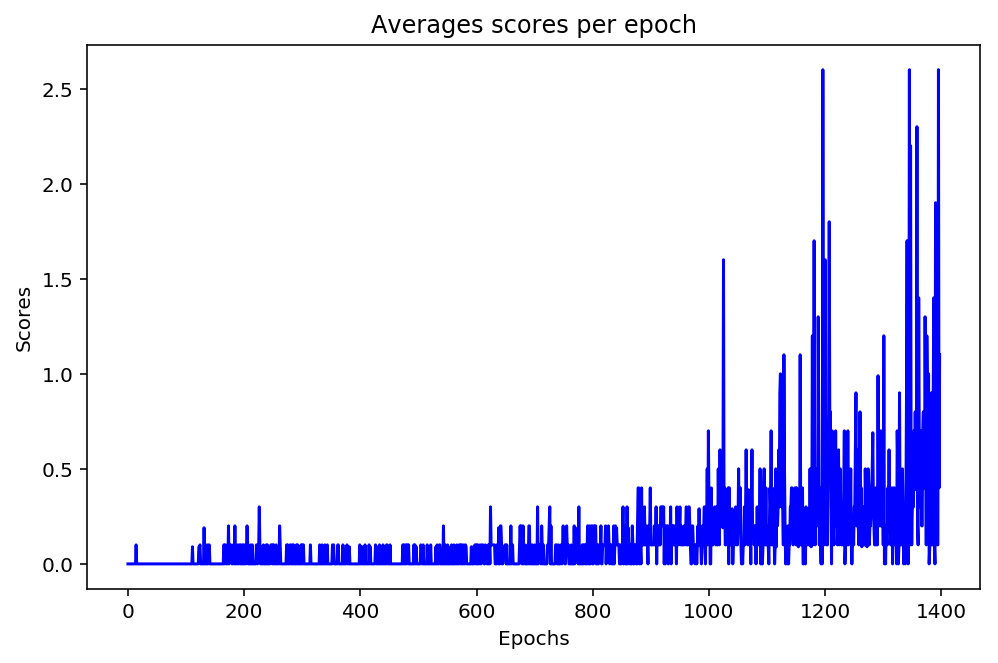

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "retina"

scores_df = pd.read_csv("scores_df.csv")

fig = plt.figure(figsize=(8,5))
plt.plot(scores_df, color="Blue");
plt.title("Averages scores per epoch");
plt.ylabel("Scores");
plt.xlabel("Epochs");